<a href="https://colab.research.google.com/github/ryuzuiin/fx-forecasting/blob/main/FRET_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# some thoughts employing FReT

1. extract different layers to build features, then import to some machiner learning algorithm

2. modify FReT algorithm to let it learning the biggest the local topology movement

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform


In [ ]:
# Import time seires from file
# data = pd.read_csv('time_series_data.csv')
# data = pd.DataFrame(data)
# data.head()
# input_data = data['Close']

In [12]:

class FReTAlgorithm:
    def __init__(self, time_series, train_test_ratio, forecast_horizon):
        self.data = pd.DataFrame(time_series)
        self.train_test_ratio = train_test_ratio
        self.forecast_horizon = forecast_horizon
        self.x_train, self.x_test = train_test_split(self.data, train_size=train_test_ratio, shuffle=False)
        self.x_train = self.x_train.reset_index(drop=True)
        self.x_test = self.x_test.reset_index(drop=True)
        self.dm = squareform(pdist(self.x_train.values.reshape(-1, 1), metric='euclidean'))
        self.LT_layers = self.extract_local_topology()
        self.flattened_layers = self.create_layers()
        self.S_im = self.create_weight_vector()
        self.FReT_forecast = self.create_forecast()

    def extract_local_topology(self):
        dm_padded = np.pad(self.dm, pad_width=1, mode='constant', constant_values=np.nan)

        def extract_LT(x):
            pos_weights = np.array([2**0, 2**1, 2**2, 2**7, 0, 2**3, 2**6, 2**5, 2**4])
            new_values = x >= x[4]
            return np.sum(pos_weights * new_values)

        extract_values = np.array([dm_padded[i:(i+3), j:(j+3)].flatten() for i in range(self.dm.shape[0]) for j in range(self.dm.shape[1])])
        LT_Output = np.array([extract_LT(x) for x in extract_values]).reshape(self.dm.shape[0], self.dm.shape[1])
        return LT_Output[1:-1, 1:-1]

    def create_layer(self, LT_layers, thresh, thresh1=None):
        layer = LT_layers.copy()
        if thresh1 is not None:
            layer[(layer < thresh) | (layer > thresh1)] = 0
            layer[(layer >= thresh) & (layer <= thresh1)] = layer[(layer >= thresh) & (layer <= thresh1)] // thresh
        else:
            layer[layer < thresh] = 0
            layer[layer >= thresh] = layer[layer >= thresh] // thresh
        return layer

    def create_layers(self):
        layer_1 = self.create_layer(self.LT_layers, 42.5)
        layer_2 = self.create_layer(self.LT_layers, 42.5, 85.5)
        layer_3 = self.create_layer(self.LT_layers, 85.5, 127.5)
        layer_4 = self.create_layer(self.LT_layers, 127.5, 170.5)
        layer_5 = self.create_layer(self.LT_layers, 170.5, 212.5)
        layer_6 = self.create_layer(self.LT_layers, 212.5)
        return layer_1 + layer_2 + layer_3 + layer_4 + layer_5 + layer_6

    def create_weight_vector(self):
        prior_states = self.flattened_layers[:-1, :]
        rv_xm = self.flattened_layers[-1, :]
        S_im = np.zeros((prior_states.shape[0], 1))
        for a in range(prior_states.shape[0]):
            rv_xi = prior_states[a, :]
            s_im_sim = np.mean(rv_xm == rv_xi)
            S_im[a, 0] = s_im_sim
        return S_im

    def create_forecast(self):
        testseqth = np.arange(0.61, 1.01, 0.01)
        S_im_opto = [np.where(self.S_im > th)[0] for th in testseqth]

        def find1(y):
            return np.where(y < (self.x_train.shape[0] - self.forecast_horizon - 2))[0]

        find1_output = [find1(opto) for opto in S_im_opto]
        find2_output = [i for i, x in enumerate(find1_output) if len(x) >= 3]
        arche = find2_output[0] if find2_output else None
        archetypes = S_im_opto[arche]
        set_arche_col = np.sum(archetypes < (self.x_train.shape[0] - self.forecast_horizon - 2))
        arche_data = np.zeros((self.forecast_horizon, set_arche_col))

        for c in range(set_arche_col):
            arche_ind = archetypes[c]
            orf = self.x_train.iloc[(arche_ind + 3):(arche_ind + self.forecast_horizon + 3)].values
            arche_data[:, c] = orf

        return np.mean(arche_data, axis=1)

    def plot_data(self):
        plt.plot(self.x_test, linewidth=4, color='black')
        plt.plot(self.FReT_forecast, linestyle='--', linewidth=4, color='red')
        plt.legend(["Test Data", "FReT"], loc='lower left', fontsize='small')
        plt.show()



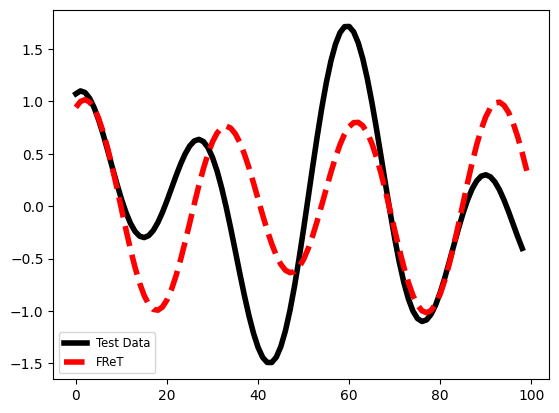

In [13]:
# Usage
your_time_series_data = np.cos(2 * np.pi * np.arange(0.1, 100, 0.1) / 3) + 0.75 * np.sin(2 * np.pi * np.arange(0.1, 100, 0.1) / 5)
train_size = 900
forecast_horizon = 100

fret_algo = FReTAlgorithm(your_time_series_data, train_size, forecast_horizon)
fret_algo.plot_data()

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Use the flattened layers as features
X_train = flattened_layers[:-forecast_horizon]
y_train = train_data['value'][forecast_horizon:]

# Train a machine learning model
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Predict on the test set
X_test = fret_algo.get_flattened_layers()[-forecast_horizon:]
y_test = test_data['value']
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


ValueError: Found input variables with inconsistent numbers of samples: [457, 459]

In [ ]:
import matplotlib.pyplot as plt

# Plot the actual vs. predicted values
plt.plot(test_data.index, y_test, label='Actual')
plt.plot(test_data.index, y_pred, label='Predicted')
plt.legend()
plt.show()


Mean Squared Error: 1.6602377853919854


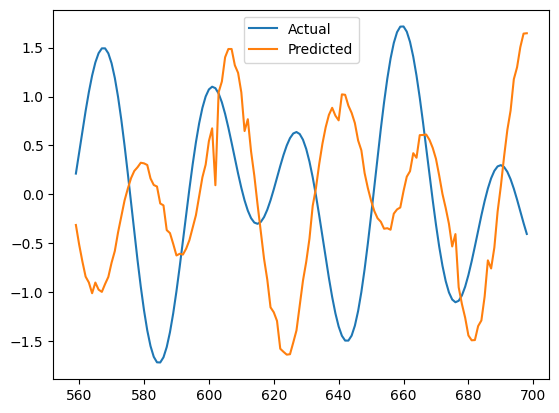

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Get the flattened layers
flattened_layers = fret_algo.get_flattened_layers()

# Ensure consistent lengths
X_train = flattened_layers[:-(forecast_horizon + 1)]
y_train = train_data['value'][len(train_data['value']) - len(X_train):].reset_index(drop=True)

# Train a machine learning model
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Predict on the test set
X_test = fret_algo.get_flattened_layers()[-len(test_data):]
y_test = test_data['value'].reset_index(drop=True)
y_pred = model.predict(X_test)

# Ensure consistent lengths for y_test and y_pred
y_test = y_test[:len(y_pred)]

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Plot the results
import matplotlib.pyplot as plt
plt.plot(test_data.index[:len(y_pred)], y_test, label='Actual')
plt.plot(test_data.index[:len(y_pred)], y_pred, label='Predicted')
plt.legend()
plt.show()
